# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import zipfile
import requests
import os
import pathlib
import numpy as np
import pathlib
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from urllib.parse import urlparse
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Sun May 21 20:03:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    18W / 370W |    328MiB / 10009MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_nn_enc_simple_dec_imdb' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [6]:
dataset_dir = os.path.join('../input', 'imdb_single_file', 'train')
train_file = os.listdir(dataset_dir)
print(train_file)

['imdb_train.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [7]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 17566362 words


In [8]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 1024
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 1

### Helper Functions 

A few helper functions to prepare the dataset.

In [9]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [10]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### The Custom Dataset Class

In [11]:
class NLPDataset():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text_file = open(file_path)
        self.lines = self.text_file.read()
        self.enc = tiktoken.encoding_for_model("gpt2")
    
    def __len__(self):
        return len(self.file_paths)

    def get_data(self):
        final_vector = self.enc.encode(self.lines)
        return torch.tensor(final_vector[0::], dtype=torch.int32)

## Prepare PyTorch Datasets and Data Loaders

In [12]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [13]:
dataset_inst = NLPDataset(file_paths)
dataset = dataset_inst.get_data()

In [14]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([22667909])
Number of unique tokens: 45163


In [15]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 20401119
Number of validation samples: 2266790


In [17]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

20401119
2266790


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
def get_batch(split='train'):
    device_type = device
    data = dataset_train if split == 'train' else dataset_valid
    ix = torch.randint(len(data) - SEQUENCE_LENGTH, (BATCH_SIZE,))
    x = torch.stack([(data[i:i+SEQUENCE_LENGTH]) for i in ix])
    y = torch.stack([(data[i+1:i+1+SEQUENCE_LENGTH]) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [20]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Training Utilities

In [21]:
# Training function.
def train(model, dataset_train, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    bleu_score = 0
    counter = 0
    for i in tqdm(
        range(0, dataset_train.size(0), SEQUENCE_LENGTH), 
        total=int(dataset_train.size(0)/SEQUENCE_LENGTH)
    ):
        counter += 1
        inputs, labels = get_batch('train')
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs)
        
        labels = labels.contiguous().view(-1)
        outputs = outputs.view(-1, NUM_WORDS)
        # Calculate the loss.
        loss = criterion(
            outputs, 
            labels.type(torch.int64)
        )
        train_running_loss += loss.item()
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    return epoch_loss

# Validation function.
def validate(model, dataset_valid, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i in tqdm(
            range(0, dataset_valid.size(0), SEQUENCE_LENGTH), 
            total=int(dataset_valid.size(0)/SEQUENCE_LENGTH)
        ):
            counter += 1
            inputs, labels = get_batch()
            # Forward pass.
            outputs = model(inputs)
        
            labels = labels.contiguous().view(-1)
            # Calculate the loss.
            loss = criterion(
                outputs.view(-1, NUM_WORDS), 
                labels.type(torch.int64)
            )
            valid_running_loss += loss.item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    return epoch_loss

## Model

In [22]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS, 
    tgt_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
    device=device
)

In [23]:
_ = model.to(device)

## Training

In [24]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [25]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, 
                             dataset_train, 
                             optimizer, 
                             criterion, 
                             device)
    valid_epoch_loss = validate(model, 
                                dataset_valid,  
                                criterion, 
                                device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 1
Training



Validation



Training loss: 5.894861221122005
Validation loss: 5.57876755788505
--------------------------------------------------


In [26]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

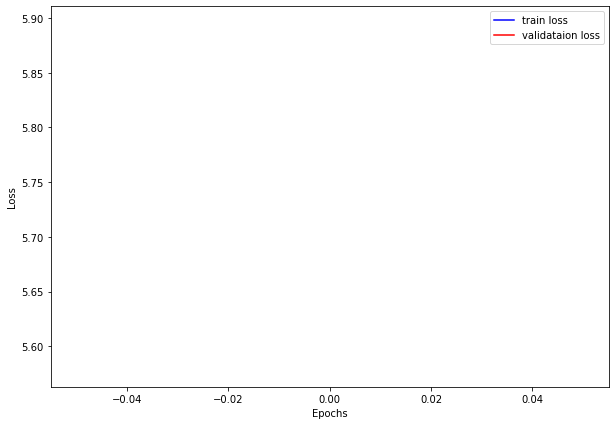

In [27]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [28]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [29]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [30]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [31]:
enc = tiktoken.encoding_for_model("gpt2")

In [32]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [33]:
generate_length = 100

In [34]:
sentences = [
    "Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers"
]

In [35]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers
GENERATED SENTENCE WITH TEMPERATURE 0.1
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers  him ,  and  a  ridiculously  obvious .  10 . < br ARS  THE  his .  (  better  chief  A  film -  Big  Gro as  only  stunt  be  horrible  plot  but  but  as  to  solid  technique  " Women . ', ." ),  Kil ney  studio  (  Wonderful  was  a  " J lee  ( I  suspect  because  he  have  to asma  so  I  felt  trying  for  Qu un 10  Bill  St .  It 's  lame  John  Payne  paint  the  film .< br ** ter  Let  " No  clue ?!  head  tiger  " the  movie  and  let  their  great  example ) < br


GENERATED SENTENCE WITH TEMPERATURE 0.2
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers  and  it  had  watched  the  short  is  just  plain  begins  to  satisfy  a 